In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Read data

In [2]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [3]:

data_train = pd.read_csv('/kaggle/input/titanic/train.csv')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')
data_train, data_train_val = train_test_split(data_train, test_size=0.2, random_state=42)
print(data_train.shape)
print(data_train_val.shape)
print(data_test.shape)

(712, 12)
(179, 12)
(418, 11)


In [4]:
data_train.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass                                Name  \
331          332         0       1                 Partner, Mr. Austen   
733          734         0       2          Berriman, Mr. William John   
382          383         0       3                  Tikkanen, Mr. Juho   
704          705         0       3             Hansen, Mr. Henrik Juul   
813          814         0       3  Andersson, Miss. Ebba Iris Alfrida   
..           ...       ...     ...                                 ...   
106          107         1       3    Salkjelsvik, Miss. Anna Kristine   
270          271         0       1               Cairns, Mr. Alexander   
860          861         0       3             Hansen, Mr. Claus Peter   
435          436         1       1           Carter, Miss. Lucile Polk   
102          103         0       1           White, Mr. Richard Frasar   

        Sex   Age  SibSp  Parch             Ticket      Fare    Cabin Embarked 

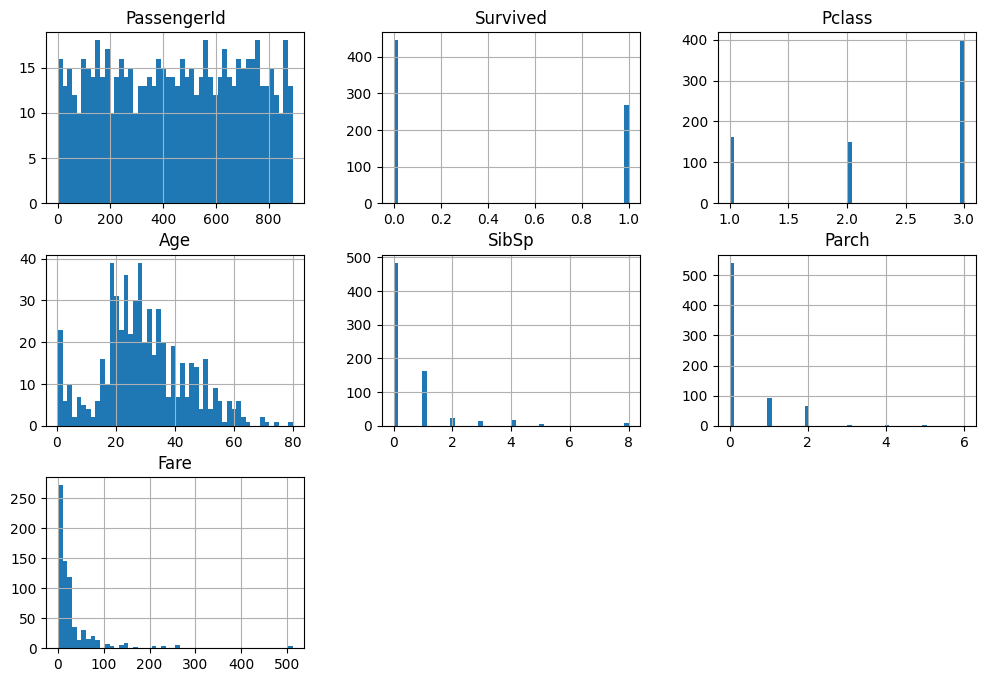

In [5]:
data_train.hist(bins=50, figsize=(12, 8))
plt.show()

## Start encoding process
* sex = (male, female) => (1,0)
* embarked = (c, q, s) => (0,1,2)

In [6]:
def encodeData(df):
    df = df.copy()
    
    sex_mapping = {'female': 0, 'male': 1}
    embark_mapping = {'C': 0, 'Q': 1, 'S': 2}
    
    df['Sex'] = df['Sex'].map(sex_mapping)
    df['Embarked'] = df['Embarked'].map(embark_mapping)
    
    df = df.drop(columns=["Name"])
    df = df.drop(columns=["Cabin"])
    df = df.drop(columns=["Ticket"])
    
    return df

data_train_processed = encodeData(data_train)

## Look for Correlations

In [7]:
corr_matrix = data_train_processed.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.246641
Parch          0.078311
PassengerId    0.019979
SibSp         -0.047602
Age           -0.059695
Embarked      -0.157497
Pclass        -0.321750
Sex           -0.541750
Name: Survived, dtype: float64

## Impute missing values

In [8]:
def impute_missing_values(df):
    df = df.copy()
    missing_values = df.isnull().sum()

    columns_with_missing_values = missing_values[missing_values > 0]

    print("Columns with missing values:")
    print(columns_with_missing_values)
    
    imputer = KNNImputer(n_neighbors = 5)
    return pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)
    
impute_missing_values(data_train_processed)

Columns with missing values:
Age         140
Embarked      2
dtype: int64


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,332.0,0.0,1.0,1.0,45.5,0.0,0.0,28.5000,2.0
733,734.0,0.0,2.0,1.0,23.0,0.0,0.0,13.0000,2.0
382,383.0,0.0,3.0,1.0,32.0,0.0,0.0,7.9250,2.0
704,705.0,0.0,3.0,1.0,26.0,1.0,0.0,7.8542,2.0
813,814.0,0.0,3.0,0.0,6.0,4.0,2.0,31.2750,2.0
...,...,...,...,...,...,...,...,...,...
106,107.0,1.0,3.0,0.0,21.0,0.0,0.0,7.6500,2.0
270,271.0,0.0,1.0,1.0,27.6,0.0,0.0,31.0000,2.0
860,861.0,0.0,3.0,1.0,41.0,2.0,0.0,14.1083,2.0
435,436.0,1.0,1.0,0.0,14.0,1.0,2.0,120.0000,2.0


In [9]:
def normalize_data(data):
    data = data.copy()
    return normalize(data)
    

In [10]:
def preprocessing(data):
    data_x = data.copy()
    data_x = encodeData(data_x)
    data_x = impute_missing_values(data_x)
    data_x.set_index('PassengerId', inplace=True)

    data_x = pd.DataFrame(normalize_data(data_x), data_x.index, data_x.columns)
    
    return data_x
    
preprocessing(data_train)

Columns with missing values:
Age         140
Embarked      2
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
332.0,0.000000,0.018606,0.018606,0.846594,0.000000,0.000000,0.530284,0.037213
734.0,0.000000,0.075218,0.037609,0.865004,0.000000,0.000000,0.488915,0.075218
383.0,0.000000,0.090420,0.030140,0.964483,0.000000,0.000000,0.238860,0.060280
705.0,0.000000,0.109349,0.036450,0.947689,0.036450,0.000000,0.286282,0.072899
814.0,0.000000,0.092709,0.000000,0.185418,0.123612,0.061806,0.966491,0.061806
...,...,...,...,...,...,...,...,...
107.0,0.044129,0.132386,0.000000,0.926701,0.000000,0.000000,0.337584,0.088257
271.0,0.000000,0.024051,0.024051,0.663807,0.000000,0.000000,0.745580,0.048102
861.0,0.000000,0.068860,0.022953,0.941089,0.045907,0.000000,0.323833,0.045907


In [11]:
def train_model(data):
    data_x = data.drop(columns=["Survived"])
    data_y = data["Survived"]
    
    data_x = preprocessing(data_x)
    
    rf = RandomForestClassifier(n_estimators=250, max_depth=5,random_state=0)
    rf.fit(data_x,data_y)
    return rf

rf = train_model(data_train)

Columns with missing values:
Age         140
Embarked      2
dtype: int64


In [12]:
rf.classes_

array([0, 1])

In [13]:
def predict_scores(data, model):
    data_x = data.drop(columns=["Survived"])
    data_y = data["Survived"]
    
    data_x = preprocessing(data_x)
    
    prediction = model.predict(data_x)
    accuracy = accuracy_score(data_y, prediction)
    return accuracy
predict_scores(data_train_val, rf)

Columns with missing values:
Age    37
dtype: int64


0.7988826815642458

In [14]:
model = rf
data_result = data_test.copy()
passenger_ids = data_result['PassengerId']
data_result = preprocessing(data_result)
predictions = model.predict(data_result) 

submission_df = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})

# Create a submission CSV file
submission_df.to_csv('submission.csv', index=False)
submission_df

Columns with missing values:
Age     86
Fare     1
dtype: int64


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
